In [46]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
from matplotlib.offsetbox import OffsetImage

from PIL import Image
import numpy as np
from io import BytesIO
import requests
# ML Libraryies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import plotly.express as px

# Graphing 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

In [47]:
#Import Stats from NFL library
qbr = nfl.import_qbr([2023])
weekly_nfl = nfl.import_weekly_data([2023])

Downcasting floats.


In [48]:
# Create DF to get epa rushing and receiving
columns = ['recent_team', 'rushing_epa', 'receiving_epa']
epa_df = weekly_nfl[columns]

epa_o = epa_df.groupby('recent_team').sum().reset_index()
epa_o.head()

,recent_team,rushing_epa,receiving_epa
0,ARI,3.666879,19.683901
1,ATL,-2.451398,-5.612046
2,BAL,0.124078,30.424280
3,BUF,12.373897,51.892578
4,CAR,-11.498089,13.846686


In [49]:
# Get NFL Logos for DF
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logo_paths = []
team_abbr = []
if not os.path.exists("logos"):
    os.makedirs("logos")

for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
logo_data = pd.DataFrame(data)

complete_epa_df = pd.merge(epa_o, logo_data, left_on = 'recent_team', right_on = 'team_abbr')
complete_epa_df.head()

,recent_team,rushing_epa,receiving_epa,team_abbr,logo_path
0,ARI,3.666879,19.683901,ARI,logos/ARI.tif
1,ATL,-2.451398,-5.612046,ATL,logos/ATL.tif
2,BAL,0.124078,30.424280,BAL,logos/BAL.tif
3,BUF,12.373897,51.892578,BUF,logos/BUF.tif
4,CAR,-11.498089,13.846686,CAR,logos/CAR.tif


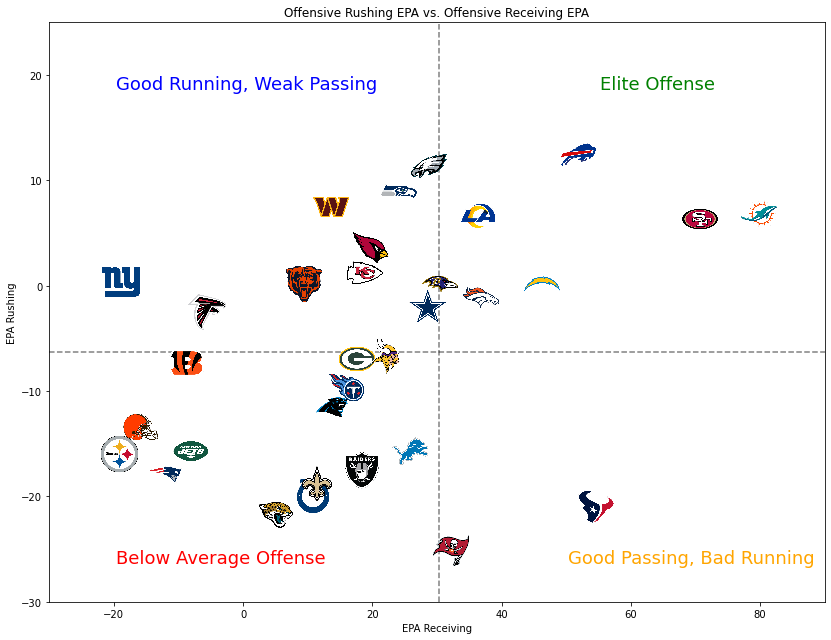

In [50]:
#Create Graph For Offensive EPA Rushing vs Receiving

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.08)

y = complete_epa_df['rushing_epa']
x = complete_epa_df['receiving_epa']
paths = complete_epa_df['logo_path']

fig, ax = plt.subplots()

# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)

plt.title("Offensive Rushing EPA vs. Offensive Receiving EPA")
plt.ylabel("EPA Rushing")
plt.xlabel("EPA Receiving")
plt.grid(False)
plt.xlim(-30, 90)
plt.ylim(-30, 25)
# Quadrant 1 
plt.text(x_mid + 25, y_mid + 25, 'Elite Offense', fontsize=18, color='green')

# Quadrant 2 
plt.text(x_mid - 50, y_mid + 25, 'Good Running, Weak Passing', fontsize=18, color='blue')

# Quadrant 3 
plt.text(x_mid - 50, y_mid - 20, 'Below Average Offense', fontsize=18, color='red')

# Quadrant 4 
plt.text(x_mid + 20, y_mid - 20, 'Good Passing, Bad Running', fontsize=18, color='orange')
#plt.savefig('fantasy_points_quadrants.png')
plt.show()
